In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from functools import partial

C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\f

<u>**MNIST data load**</u>

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

def shuffle_batch(features, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x = features[batch_idx]
        yield batch_x

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_x = mnist.train.images # image만 필요. label(y)은 필요없다.
train_x = train_x.astype(np.float32).reshape(-1,28*28)  # (이미지 데이터 수, 28*28)

valid_x, train_x = train_x[:5000], train_x[5000:]

W0826 01:04:38.829847 11492 deprecation.py:323] From <ipython-input-3-9213001b689d>:3: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0826 01:04:38.830826 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0826 01:04:38.831832 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0826 01:04:39.038289 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0826 01:04:39.041304 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0826 01:04:39.082151 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


![stacked-autoencoder](assets/stacked-autoencoder.png)

In [4]:
tf.reset_default_graph()

## layer parameter
n_inputs = 28*28
n_hidden1 = 400       # encoder
n_hidden2 = 200       # coding units
n_hidden3 = n_hidden1 # decoder
n_outputs = n_inputs  # restruction

## train parameter
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

## 레이어 구성
he_init = tf.keras.initializers.he_normal() # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg) # L2 규제

# partial 을 이용한 tf.layers.dense 의 새 버전 만들기
# partial 첫번째 인자는 새 버전 만들 원본.
# 나머지 인자는 원본 함수가 갖는 인자를 재정의 하는데 쓰인다.
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.relu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

# Stacked Automater 구성
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)

outputs = dense_layer(hidden3, n_outputs, activation=None)

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs)) # mse
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

W0826 01:04:39.415263 11492 deprecation.py:323] From <ipython-input-4-82a29273d025>:32: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [5]:
%%time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for _ in range(n_batches):
            batch_x = next(shuffle_batch(train_x, batch_size))
            _, _loss = sess.run([train_op, reconstruction_loss], feed_dict={inputs:batch_x})
        print(f'epoch: {epoch+1}/{n_epochs}, Train MSE: {_loss:.10f}')
            
    saver.save(sess, 'stacked_autoencoder.ckpt')

epoch: 1/5, Train MSE: 0.0271446239
epoch: 2/5, Train MSE: 0.0234497748
epoch: 3/5, Train MSE: 0.0226598140
epoch: 4/5, Train MSE: 0.0222074222
epoch: 5/5, Train MSE: 0.0211579707
Wall time: 12.9 s


W0826 01:04:52.848343 11492 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


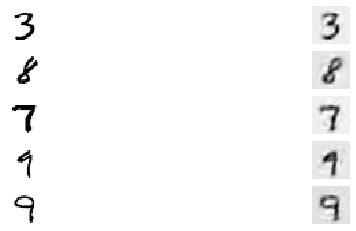

In [6]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = sess.run(outputs, feed_dict={inputs:train_x[:n_test_digits]})
        
        fig = plt.figure(figsize=(10,4))
        for digit_index in range(n_test_digits):
            plt.subplot(n_test_digits, 2, digit_index*2+1)
            plot_image(train_x[digit_index])
            plt.subplot(n_test_digits, 2, digit_index*2+2)
            plot_image(outputs_val[digit_index])

show_reconstructed_digits(inputs, outputs, 'stacked_autoencoder.ckpt', 5)